In [4]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [7]:
tf.config.list_physical_devices('GPU')

[]

In [6]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

In [8]:
import gdown

In [9]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From (original): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=86c38957-d76a-4881-879b-e7fcd318784f
To: c:\Users\Asus\OneDrive\Documents\vscode_python\new_app\projects\data.zip
100%|██████████| 423M/423M [03:31<00:00, 2.00MB/s] 


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [10]:
def load_video(path:str) -> List[float]: 

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [11]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [13]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [14]:
char_to_num(['g','i','r','i','s','h'])

<tf.Tensor: shape=(6,), dtype=int64, numpy=array([ 7,  9, 18,  9, 19,  8], dtype=int64)>

In [15]:
num_to_char([ 7,  9, 18,  9, 19,  8])
#b is byte encoded

<tf.Tensor: shape=(6,), dtype=string, numpy=array([b'g', b'i', b'r', b'i', b's', b'h'], dtype=object)>

In [16]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [17]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [18]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    #file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [19]:
test_path = '.\\data\\s1\\bbal6n.mpg'

tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

'bbal6n'

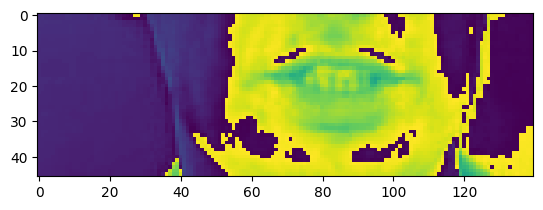

In [25]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

plt.imshow(frames[35])

In [22]:
#alignments
alignments
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [26]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

In [27]:
from matplotlib import pyplot as plt
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split 
train = data.take(450)
test = data.skip(450)

In [29]:
len(test)
frames, alignments = data.as_numpy_iterator().next()
len(frames)
sample = data.as_numpy_iterator()

In [34]:
val = sample.next(); val[0]

array([[[[[1.5250725 ],
          [1.4869456 ],
          [1.5631993 ],
          ...,
          [0.3050145 ],
          [0.3050145 ],
          [0.3050145 ]],

         [[1.6394529 ],
          [1.4869456 ],
          [1.4488188 ],
          ...,
          [0.3050145 ],
          [0.3050145 ],
          [0.3050145 ]],

         [[1.5250725 ],
          [1.5250725 ],
          [1.5250725 ],
          ...,
          [0.34314132],
          [0.3050145 ],
          [0.3050145 ]],

         ...,

         [[1.029424  ],
          [1.029424  ],
          [1.029424  ],
          ...,
          [0.        ],
          [0.        ],
          [0.        ]],

         [[1.029424  ],
          [1.029424  ],
          [1.029424  ],
          ...,
          [0.        ],
          [0.        ],
          [0.        ]],

         [[1.029424  ],
          [1.029424  ],
          [1.029424  ],
          ...,
          [0.        ],
          [0.        ],
          [0.        ]]],


        [[[1.5250

In [43]:
imageio.mimsave('./animation.gif', val[0][1], fps=10)

TypeError: Cannot handle this data type: (1, 1, 1), <f4

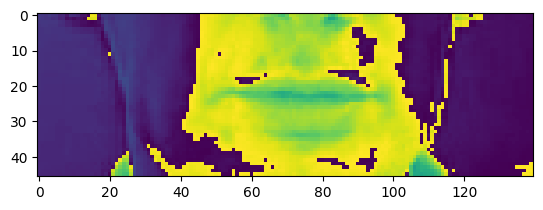

In [41]:
plt.imshow(val[0][0][35])

In [42]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'set green by j three again'>

In [78]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ModelCheckpoint

In [46]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [48]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

ValueError: Could not interpret initializer identifier: Orthogonal

In [50]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_3 (Conv3D)               │ (None, 75, 46, 140,    │         3,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 75, 46, 140,    │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 75, 23, 70,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_4 (Conv3D)               │ (None, 75, 23, 70,     │       884,992 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 75, 23, 70,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_4 (MaxPooling3D)  │ (None, 75, 11, 35,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_5 (Conv3D)               │ (None, 75, 11, 35, 75) │       518,475 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 75, 11, 35, 75) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_5 (MaxPooling3D)  │ (None, 75, 5, 17, 75)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 75, 6375)       │             0 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,407,051 (5.37 MB)

 Trainable params: 1,407,051 (5.37 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
5*17*75

6375

In [52]:
yhat = model.predict(val[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


In [53]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b''>

In [54]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b''>

In [55]:
model.input_shape

(None, 75, 46, 140, 1)

In [56]:
model.output_shape

(None, 75, 6375)

In [57]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [58]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [59]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [60]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [81]:
checkpoint_callback = ModelCheckpoint(os.path.join('\\models.weights.h5'), monitor='loss', save_weights_only=True) 

In [82]:
schedule_callback = LearningRateScheduler(scheduler)

example_callback = ProduceExample(test)


In [ ]:
model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/100



InvalidArgumentError: Graph execution error:

Detected at node sequential_1_1/time_distributed_1_1/Reshape_3 defined at (most recent call last):
  File "c:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main

  File "c:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code

  File "C:\Users\Asus\AppData\Roaming\Python\Python310\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "C:\Users\Asus\AppData\Roaming\Python\Python310\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "C:\Users\Asus\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "c:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "c:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 595, in run_forever

  File "c:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1881, in _run_once

  File "c:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Asus\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue

  File "C:\Users\Asus\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 534, in process_one

  File "C:\Users\Asus\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "C:\Users\Asus\AppData\Roaming\Python\Python310\site-packages\ipykernel\ipkernel.py", line 362, in execute_request

  File "C:\Users\Asus\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 778, in execute_request

  File "C:\Users\Asus\AppData\Roaming\Python\Python310\site-packages\ipykernel\ipkernel.py", line 449, in do_execute

  File "C:\Users\Asus\AppData\Roaming\Python\Python310\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "C:\Users\Asus\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell

  File "C:\Users\Asus\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell

  File "C:\Users\Asus\AppData\Roaming\Python\Python310\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "C:\Users\Asus\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async

  File "C:\Users\Asus\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes

  File "C:\Users\Asus\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code

  File "C:\Users\Asus\AppData\Local\Temp\ipykernel_24744\3536403359.py", line 1, in <module>

  File "c:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 314, in fit

  File "c:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 117, in one_step_on_iterator

  File "c:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 104, in one_step_on_data

  File "c:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 51, in train_step

  File "c:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\layer.py", line 846, in __call__

  File "c:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\ops\operation.py", line 48, in __call__

  File "c:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "c:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\models\sequential.py", line 209, in call

  File "c:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\models\functional.py", line 202, in call

  File "c:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\ops\function.py", line 155, in _run_through_graph

  File "c:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\models\functional.py", line 592, in call

  File "c:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\layer.py", line 846, in __call__

  File "c:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\ops\operation.py", line 48, in __call__

  File "c:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "c:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\time_distributed.py", line 108, in call

  File "c:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\time_distributed.py", line 108, in <listcomp>

  File "c:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\time_distributed.py", line 102, in step_function

  File "c:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\reshaping\flatten.py", line 54, in call

  File "c:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\ops\numpy.py", line 4415, in reshape

  File "c:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\backend\tensorflow\numpy.py", line 1778, in reshape

Only one input size may be -1, not both 0 and 1
	 [[{{node sequential_1_1/time_distributed_1_1/Reshape_3}}]] [Op:__inference_one_step_on_iterator_55018]

In [85]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

Downloading...
From (original): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
From (redirected): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y&confirm=t&uuid=309c1cc5-e090-4344-91a4-8896d9c846d7
To: c:\Users\Asus\OneDrive\Documents\vscode_python\new_app\projects\checkpoints.zip
100%|██████████| 94.5M/94.5M [00:33<00:00, 2.81MB/s]


['models\\checkpoint.index',
 'models\\__MACOSX/._checkpoint.index',
 'models\\checkpoint.data-00000-of-00001',
 'models\\__MACOSX/._checkpoint.data-00000-of-00001',
 'models\\checkpoint',
 'models\\__MACOSX/._checkpoint']

In [86]:
model.load_weights('models/checkpoint')

ValueError: File format not supported: filepath=models/checkpoint. Keras 3 only supports V3 `.keras` and `.weights.h5` files, or legacy V1/V2 `.h5` files.

In [87]:
test_data = test.as_numpy_iterator()
sample = test_data.next()
yhat = model.predict(sample[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


In [88]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'place red by x two now'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'place red by x three soon'>]

In [89]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b''>,
 <tf.Tensor: shape=(), dtype=string, numpy=b''>]

In [ ]:
sample = load_data(tf.convert_to_tensor('.\\data\\s1\\bras9a.mpg'))
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

In [ ]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

In [90]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

FailedPreconditionError: {{function_node __wrapped__CTCGreedyDecoder_device_/job:localhost/replica:0/task:0/device:CPU:0}} len(sequence_length) != batch_size.  len(sequence_length):  1 batch_size: 2 [Op:CTCGreedyDecoder] name: 